Simulating crosstalk between detectors
====

In this notebook, we show how to simulate crosstalk between detectors using s4cmb.

In [1]:
## In case you did not install properly the library 
## or didn't update your bashrc. (Do it later!)
import os
path_to_s4cmb = '../../s4cmb'
os.sys.path.insert(0, os.path.realpath(path_to_s4cmb))

## Import basic modules and routines
from __future__ import division, absolute_import, print_function

import healpy as hp
import pylab as pl
import numpy as np

## Import modules and routines from s4cmb
from s4cmb.input_sky import HealpixFitsMap

from s4cmb.instrument import Hardware

from s4cmb.scanning_strategy import ScanningStrategy

from s4cmb.tod import TimeOrderedDataPairDiff
from s4cmb.tod import OutputSkyMap
from s4cmb.tod import partial2full

from s4cmb.systematics import inject_crosstalk_inside_SQUID

try:
    from tqdm import *
except ImportError:
    tqdm = lambda x: x

Flow is the following: 
sky + instrument + scanning strategy --> 
map2tod --> inject crosstalk --> tod2map.

Initialise our instrument, scanning strategy and input maps as seen in the previous lectures. But this time, we will perform 12 scans:

In [2]:
## Instrument
inst = Hardware(ncrate=4, ndfmux_per_crate=1,
                nsquid_per_mux=1, npair_per_squid=16,
                fp_size=60., fwhm=3.5, 
                beam_seed=58347, projected_fp_size=3., pm_name='5params',
                type_hwp='CRHWP', freq_hwp=2., angle_hwp=0., verbose=False)

## Input maps
nside = 512
path_to_cls = '../../s4cmb/s4cmb/data/test_data_set_lensedCls.dat'
sky_in = HealpixFitsMap(path_to_cls, do_pol=True, 
                        fwhm_in=inst.beam_model.fwhm, nside_in=nside, 
                        map_seed=5843787, verbose=False, 
                        no_ileak=False, no_quleak=False)

## Scanning strategy
scan = ScanningStrategy(nces=2, start_date='2013/1/1 00:00:00',
                        telescope_longitude='-67:46.816',
                        telescope_latitude='-22:56.396', telescope_elevation=5200.,
                        name_strategy='deep_patch', sampling_freq=8., sky_speed=0.4,
                        ut1utc_fn='../../s4cmb/s4cmb/data/ut1utc.ephem', 
                        language='fortran')
scan.run()

Let's now generate our TOD from our input sky, instrument, and scanning strategy
We will use the difference of pairs of detectors to reconstruct 
the polarisation (no demodulation).
Once we will have the timestreams, we will reconstruct our maps on a 
sky patch of width 130 deg at a resolution nside = 512.

Let's also inject crosstalk in our data!
We will assume that all the detectors within a SQUID are crosstalking
with coefficients drawn from a Gaussian distribution (mu=-10%, sigma=5%).
We will also assume that the crosstalk is time-independent (that is fix the seed of
the distribution).
For visualisation purposes, we will return a new array of modified timestream 
(in practice,  you will overwrite the original array to save memory).

In [3]:
## Indices of SQUIDs and bolometers in the focal plane
squid_ids = inst.focal_plane.get_indices('Sq')
bolo_ids = inst.focal_plane.bolo_index_in_squid

## Loop over CESs
for CESnumber in range(scan.nces):
    tod = TimeOrderedDataPairDiff(
        inst, scan, sky_in, 
        CESnumber=CESnumber, 
        projection='healpix', 
        pixel_size=None, nside_out=nside, 
        array_noise_level=None, array_noise_seed=None,
        width=130., mapping_perpair=False)
    
    ## Initialise map containers
    if CESnumber == 0:
        sky_out_tot = OutputSkyMap(
            projection=tod.projection,
            nside=tod.nside_out,
            obspix=tod.obspix,
            npixsky=tod.npixsky,
            pixel_size=tod.pixel_size)
        
        sky_out_tot_mod = OutputSkyMap(
            projection=tod.projection,
            nside=tod.nside_out,
            obspix=tod.obspix,
            npixsky=tod.npixsky,
            pixel_size=tod.pixel_size)
        
    ## Scan input map to get TODs
    d = np.array(
        [tod.map2tod(det) for det in tqdm(
                range(inst.focal_plane.nbolometer))])
        
    ## Inject crosstalk
    d_mod = np.zeros_like(d)
    inject_crosstalk_inside_SQUID(
        d, squid_ids, bolo_ids,
        mu=-10., sigma=5.,
        radius=2*inst.focal_plane.npair_per_squid,
        seed=5438765,
        new_array=d_mod)
    
    ## Project TOD to maps
    tod.tod2map(d, sky_out_tot)
    tod.tod2map(d_mod, sky_out_tot_mod)

100%|██████████| 128/128 [00:06<00:00, 20.24it/s]


Note that the coaddition of different scans is done internally to tod2map (that is we keep accumulating the data in sky_out_tot). If you are using MPI, you need however to explicitly make the coaddition (using coadd_MPI). We will see an example later on. Note also that in this example (crosstalk), the detectors timestreams are correlated, so you need to set mapping_perpair=False. Let's have a look at the TOD:

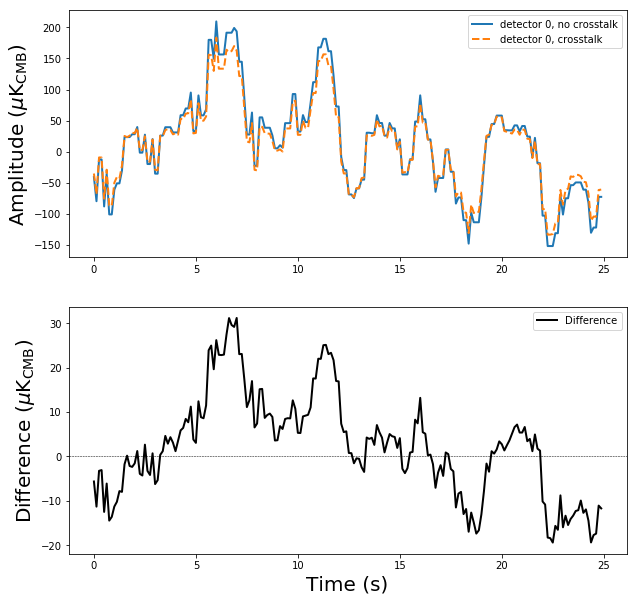

In [4]:
stop = 200
xaxis = [t/scan.sampling_freq for t in range(0, stop)]

fig, ax = pl.subplots(2, 1, figsize=(10, 10))

ax[0].plot(xaxis, d[0][0:stop], label='detector 0, no crosstalk', lw=2)
ax[0].plot(xaxis, d_mod[0][0:stop], label='detector 0, crosstalk', ls='--', lw=2)
ax[0].legend()
ax[0].set_ylabel('Amplitude ($\mu$K$_{\\rm CMB}$)', fontsize=20)

ax[1].plot(xaxis, d[0][0:stop] - d_mod[0][0:stop], label='Difference', lw=2, color='black')
ax[1].axhline(0, ls='--', color='black', lw=0.5)
ax[1].set_xlabel('Time (s)', fontsize=20)
ax[1].set_ylabel('Difference ($\mu$K$_{\\rm CMB}$)', fontsize=20)

pl.legend()
pl.show()

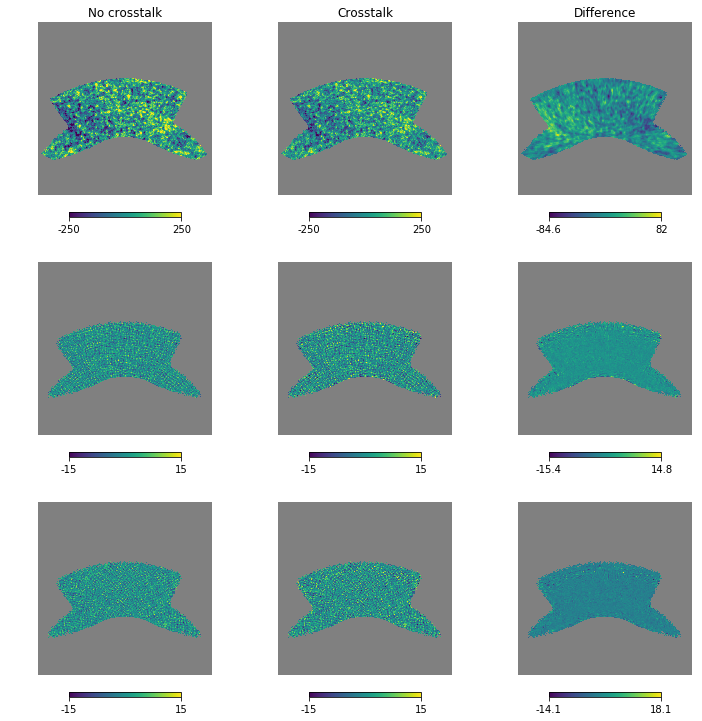

In [6]:
## Let's check the output maps
xsize = 600
fig = pl.figure(figsize=(10, 10))
nhit = partial2full(sky_out_tot.nhit, sky_out_tot.obspix, 
                       sky_out_tot.nside, fill_with=0.0)

## Temperature
sky_out = partial2full(sky_out_tot.get_I(), sky_out_tot.obspix, 
                       sky_out_tot.nside, fill_with=0.0)
sky_out_mod = partial2full(sky_out_tot_mod.get_I(), sky_out_tot_mod.obspix, 
                           sky_out_tot_mod.nside, fill_with=0.0)
mask = nhit < 1
sky_out[mask] = np.nan
sky_out_mod[mask] = np.nan
hp.gnomview(sky_out, rot=[0, -57.5], xsize=xsize, reso=6.9, sub=331, 
            title='No crosstalk', notext=True, min=-250, max=250)
hp.gnomview(sky_out_mod, rot=[0, -57.5], xsize=xsize, reso=6.9, sub=332, 
            title='Crosstalk', notext=True, min=-250, max=250)
hp.gnomview(sky_out_mod - sky_out, rot=[0, -57.5], xsize=xsize, reso=6.9, sub=333, 
            title='Difference', notext=True)

## Stokes Q
sky_out = partial2full(sky_out_tot.get_QU()[0], sky_out_tot.obspix, 
                       sky_out_tot.nside, fill_with=0.0)
sky_out_mod = partial2full(sky_out_tot_mod.get_QU()[0], sky_out_tot_mod.obspix, 
                           sky_out_tot_mod.nside, fill_with=0.0)
mask = nhit < np.max(nhit)/20
sky_out_mod[mask] = np.nan
sky_out[mask] = np.nan
hp.gnomview(sky_out, rot=[0, -57.5], xsize=xsize, reso=6.9, sub=334, 
            notext=True, min=-15, max=15, title='')
hp.gnomview(sky_out_mod, rot=[0, -57.5], xsize=xsize, reso=6.9, sub=335,  
            notext=True, min=-15, max=15, title='')
hp.gnomview(sky_out_mod - sky_out, rot=[0, -57.5], xsize=xsize, reso=6.9, sub=336, 
            notext=True, title='')

## Stokes U
sky_out = partial2full(sky_out_tot.get_QU()[1], sky_out_tot.obspix, 
                       sky_out_tot.nside, fill_with=0.0)
sky_out_mod = partial2full(sky_out_tot_mod.get_QU()[1], sky_out_tot_mod.obspix, 
                           sky_out_tot_mod.nside, fill_with=0.0)
mask = nhit < np.max(nhit)/20
sky_out_mod[mask] = np.nan
sky_out[mask] = np.nan
hp.gnomview(sky_out, rot=[0, -57.5], xsize=xsize, reso=6.9, sub=337, 
            notext=True, min=-15, max=15, title='')
hp.gnomview(sky_out_mod, rot=[0, -57.5], xsize=xsize, reso=6.9, sub=338, 
            notext=True, min=-15, max=15, title='')
hp.gnomview(sky_out_mod - sky_out, rot=[0, -57.5], xsize=xsize, reso=6.9, sub=339, 
            notext=True, title='')
pl.show()

Here it is! Notice that in this simple example, the crosstalk signal follows the intensity map.
For SO members, you can find the latest results using the pipeline here: http://simonsobservatory.wikidot.com/instrument-systematic-systmodule.